# Numerically stable calculation of invariant mass

The art of writing numerical stable formulas is to find a mathematically equivalent computation for a formula that produces accurate results even though computation with floating point numbers suffers from finite precision and round-off. We derive here numerically stable formulas for the calculation of the invariant mass of an ancestor particle in particle physics from the momenta and (assumed) masses of its products.

## Two-body decay

We start with a derivation of a numerically stable formula for the 1D case, and then move to the general 3D case. The 1D solution is not applicable in practice, but it is easier to understand one of the two main numerical issues with the naive implementation when we start in 1D.

### Solution in 1D

We start with the formula for the invariant mass squared of an ancestor particle which decays into two children,

$$
M^2 = m_1^2  + m_2^2 + 2 (E_1 E_2 - \vec{p}_1 \vec{p}_2).
$$

For small $m_i$, we have a catastrophic cancelation in the third term. In floating point precision, the third term can be zero, even if the masses are small but positive. Due to round-off errors, it is even possible that the third term gets negative.

To fix this, we rewrite the product of the energies

$$
E_1 E_2 = \sqrt{|\vec{p}_1|^2 + m_1^2}\sqrt{|\vec{p}_2| + m_2^2} = |\vec{p}_1| |\vec{p}_2| \sqrt{\left(1 + \frac{m_1^2}{|\vec{p}_1|^2}\right)\left(1 + \frac{m_2^2}{|\vec{p}_2|^2}\right)} = |\vec{p}_1| |\vec{p}_2| \sqrt{1 + x}
$$

with

$$
x = \frac{m_1^2}{|\vec{p}_1|^2} + \frac{m_2^2}{|\vec{p}_2|^2} + \frac{m_1^2}{|\vec{p}_1|^2} \frac{m_2^2}{|\vec{p}_2|^2}
$$

In 1D, we have (assuming parallel vectors)

$$
E_1 E_2 - \vec{p}_1 \vec{p}_2 = E_1 E_2 - |\vec{p}_1||\vec{p}_2| = |\vec{p}_1||\vec{p}_2| (\sqrt{x + 1} - 1)
$$

The cancellation is now reduced to the expression $\sqrt{x + 1} - 1$. With a [brilliant trick from Stackoverflow](https://stackoverflow.com/questions/32444817/numerically-stable-evaluation-of-sqrtxa-sqrtx?rq=1), we can rewrite this as

$$
\sqrt{x + 1} - 1 = \frac{(\sqrt{x + 1} - 1)(\sqrt{x + 1} + 1)}{\sqrt{x + 1} + 1} = \frac{x}{\sqrt{x + 1} + 1}
$$

which is numerically stable, as the following plot demonstrates.

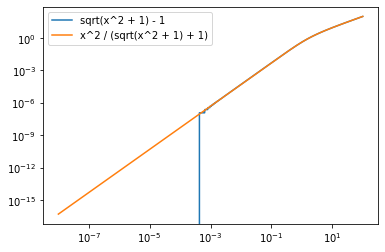

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.geomspace(1e-8, 1e2, 1000).astype(np.float32)

plt.plot(x, np.sqrt(x ** 2 + 1) - 1, label="sqrt(x^2 + 1) - 1")
plt.plot(x, x ** 2 / (np.sqrt(x ** 2 + 1) + 1), label="x^2 / (sqrt(x^2 + 1) + 1)")
plt.loglog()
plt.legend();

The rewritten formula for $M^2$ produces a value that **is always non-negative** even in the presence of round-off errors. This is a common issue with naive implementations even in double precision. 

Below, we compare a naive implementation `msq1` with the numerically stable implementation `msq2` on random values. The reference is computed with the naive implementation using `mpmath` on floating point numbers with 100 digits of precision.

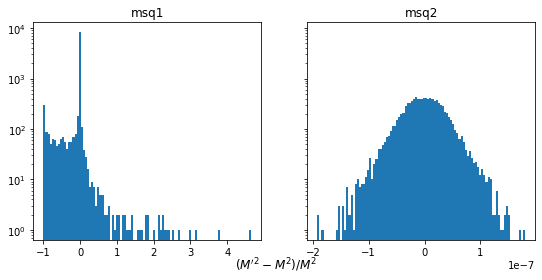

In [2]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import mpmath as mp

# naive implementation
def msq1(p1, p2, m1, m2):
    m1_sq = m1 ** 2
    m2_sq = m2 ** 2
    
    # energies of particles 1 and 2
    e1 = np.sqrt(p1 ** 2 + m1_sq)
    e2 = np.sqrt(p2 ** 2 + m2_sq)

    # dangerous cancelation in third term
    return m1_sq + m2_sq + 2 * (e1 * e2 - p1 * p2)


# numerically stable implementation
@nb.vectorize
def msq2(p1, p2, m1, m2):
    x1 = (m1 / p1) ** 2
    x2 = (m2 / p2) ** 2
    x = x1 + x2 + x1 * x2
    y = 2 * p1 * p2 * x / (np.sqrt(1 + x) + 1)
    return m1 ** 2 + m2 ** 2 + y


rng = np.random.default_rng(1)

p1 = 10 ** rng.uniform(0, 5, size=10000).astype(np.float32)
p2 = 10 ** rng.uniform(0, 5, size=10000).astype(np.float32)
m1 = 10 ** rng.uniform(-5, 5, size=10000).astype(np.float32)
m2 = 10 ** rng.uniform(-5, 5, size=10000).astype(np.float32)

# as reference we use naive formula computed with mpmath
M0 = []
with mp.workdps(100):
    for p1i, p2i, m1i, m2i in zip(p1, p2, m1, m2):        
        p1i = mp.mpf(float(p1i))
        p2i = mp.mpf(float(p2i))
        
        m1_sq = mp.mpf(float(m1i)) ** 2
        m2_sq = mp.mpf(float(m2i)) ** 2

        e1 = mp.sqrt(p1i ** 2 + m1_sq)
        e2 = mp.sqrt(p2i ** 2 + m2_sq)

        M0.append(float(m1_sq + m2_sq + 2 * (e1 * e2 - p1i * p2i)))

M0 = np.array(M0)

M = {f.__name__: f(p1, p2, m1, m2) for f in (msq1, msq2)}

fig, ax = plt.subplots(1, len(M), figsize=(len(M) * 4.5, 4), sharey=True)
for (fname, Mi), axi in zip(M.items(), ax):    
    axi.hist((Mi - M0) / M0, bins=100)
    axi.set_yscale("log")
    axi.set_title(fname)
fig.supxlabel(r"$(M'^2 - M^2) / M^2$");

The numerically stable formula retains full accuracy, while the naive formula suffers a catastrophic loss of accuracy for certain input values.

### Solution in 3D

In 3D, the solution is more complex than in the 1D case. We have now

$$
E_1 E_2 - \vec{p}_1 \vec{p}_2 = |\vec{p}_1| |\vec{p}_2| \left(\sqrt{x + 1} - \frac{\vec{p}_1 \vec{p}_2}{|\vec{p}_1| |\vec{p}_2|}\right) = |\vec{p}_1| |\vec{p}_2| \left(\sqrt{x + 1} - \cos{\alpha}\right)
$$

where $\alpha$ is the angle between $\vec{p}_1$ and $\vec{p}_2$. We have again a numerical instability for small $x$ and small $\alpha$, when $\vec{p}_1$ and $\vec{p}_2$ are nearly parallel, which happens often in practice.

To avoid the cancelation in the subtraction of two numbers close to 1, we use the same trick as before, but get a different outcome

$$
\sqrt{x + 1} - \cos{\alpha} = \frac{x + 1 - \cos^2{\alpha}}{\sqrt{x + 1} + \cos{\alpha}} = \frac{x + \sin^2{\alpha}}{\sqrt{x + 1} + \cos{\alpha}}.
$$

This time we only replace the left-hand side with the right-hand side if $\cos{\alpha} > 0$, since for other values of the cosine, there is no subtraction happening. The expression is again guaranteed to produce a non-negative value even in the presence of round-off errors.

So far so good, but we face an additional issue. The naive computation of $\alpha$ is also not numerically stable for small $\alpha$ and we need [another trick from Stackoverflow](https://scicomp.stackexchange.com/questions/27689/numerically-stable-way-of-computing-angles-between-vectors) to compute it accurately,

$$
\alpha = \rm{arctan2}(|\vec{p}_1 \times \vec{p}_2|, \vec{p}_1 \vec{p}_2 )
$$

where $\rm{arctan2}$ refers to the computer function with the same name.

We again compare a naive implementation `msq1` with the numerically stable version `msq2` on random inputs.

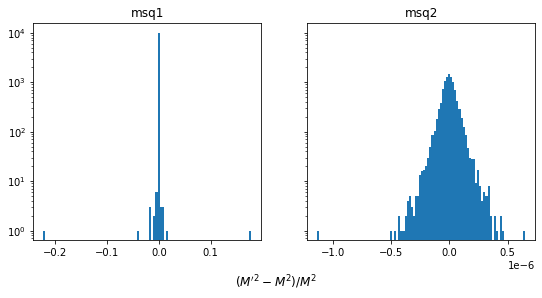

In [3]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import mpmath as mp

# naive implementation
def msq1(px1, py1, pz1, px2, py2, pz2, m1, m2):
    p1_sq = px1 ** 2 + py1 ** 2 + pz1 ** 2
    p2_sq = px2 ** 2 + py2 ** 2 + pz2 ** 2
    m1_sq = m1 ** 2
    m2_sq = m2 ** 2
    
    # energies of particles 1 and 2
    e1 = np.sqrt(p1_sq + m1_sq)
    e2 = np.sqrt(p2_sq + m2_sq)

    # dangerous cancelation in third term
    return m1_sq + m2_sq + 2 * (e1 * e2 - (px1 * px2 + py1 * py2 + pz1 * pz2))


# numerically stable implementation
@nb.vectorize
def msq2(px1, py1, pz1, px2, py2, pz2, m1, m2):
    p1_sq = px1 ** 2 + py1 ** 2 + pz1 ** 2
    p2_sq = px2 ** 2 + py2 ** 2 + pz2 ** 2
    m1_sq = m1 ** 2
    m2_sq = m2 ** 2
    x1 = m1_sq / p1_sq
    x2 = m2_sq / p2_sq
    x = x1 + x2 + x1 * x2
    a = angle(px1, py1, pz1, px2, py2, pz2)
    cos_a = np.cos(a)
    if cos_a >= 0:
        y1 = (x + np.sin(a) ** 2) / (np.sqrt(x + 1) + cos_a) 
    else:
        y1 = -cos_a + np.sqrt(x + 1) 
    y2 = 2 * np.sqrt(p1_sq * p2_sq)
    return m1_sq + m2_sq + y1 * y2


# numerically stable calculation of angle
@nb.njit
def angle(x1, y1, z1, x2, y2, z2):
    # cross product
    cx = y1 * z2 - y2 * z1
    cy = x1 * z2 - x2 * z1
    cz = x1 * y2 - x2 * y1
    
    # norm of cross product
    c = np.sqrt(cx * cx + cy * cy + cz * cz)
    
    # dot product
    d = x1 * x2 + y1 * y2 + z1 * z2
    
    return np.arctan2(c, d)


rng = np.random.default_rng(1)

dtype = np.float32
size = 10000
px1 = (10 ** rng.uniform(0, 5, size=size) * rng.choice([-1, 1], size=size)).astype(dtype)
py1 = (10 ** rng.uniform(0, 5, size=size) * rng.choice([-1, 1], size=size)).astype(dtype)
pz1 = (10 ** rng.uniform(0, 5, size=size) * rng.choice([-1, 1], size=size)).astype(dtype)
px2 = (10 ** rng.uniform(0, 5, size=size) * rng.choice([-1, 1], size=size)).astype(dtype)
py2 = (10 ** rng.uniform(0, 5, size=size) * rng.choice([-1, 1], size=size)).astype(dtype)
pz2 = (10 ** rng.uniform(0, 5, size=size) * rng.choice([-1, 1], size=size)).astype(dtype)
m1 = 10 ** rng.uniform(-5, 5, size=size).astype(dtype)
m2 = 10 ** rng.uniform(-5, 5, size=size).astype(dtype)

# as reference we use naive formula computed with mpmath
M0 = []
with mp.workdps(100):
    for px1i, py1i, pz1i, px2i, py2i, pz2i, m1i, m2i in zip(px1, py1, pz1, px2, py2, pz2, m1, m2):
        px1i = mp.mpf(float(px1i))
        py1i = mp.mpf(float(py1i))
        pz1i = mp.mpf(float(pz1i))
        px2i = mp.mpf(float(px2i))
        py2i = mp.mpf(float(py2i))
        pz2i = mp.mpf(float(pz2i))
        
        m1_sq = mp.mpf(float(m1i)) ** 2
        m2_sq = mp.mpf(float(m2i)) ** 2

        e1 = mp.sqrt(px1i ** 2 + py1i ** 2 + pz1i ** 2 + m1_sq)
        e2 = mp.sqrt(px2i ** 2 + py2i ** 2 + pz2i ** 2 + m2_sq)

        M0.append(float(m1_sq + m2_sq + 2 * (e1 * e2 - (px1i * px2i + py1i * py2i + pz1i * pz2i))))

M0 = np.array(M0)

M = {f.__name__: f(px1, py1, pz1, px2, py2, pz2, m1, m2) for f in (msq1, msq2)}

fig, ax = plt.subplots(1, len(M), figsize=(len(M) * 4.5, 4), sharey=True)
for (fname, Mi), axi in zip(M.items(), ax):
    d = (Mi - M0) / M0
    axi.hist(d, bins=100)
    axi.set_yscale("log")
    axi.set_title(f"{fname}")
fig.supxlabel(r"$(M'^2 - M^2) / M^2$", y=-0.05);

We again see great loss of accuracy for the naive implementation, while the numerically stable formula produces accurate results.